In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_wine
import warnings
warnings.filterwarnings("ignore")

## Loading data, looking at some correlations and class 'disorganization'

In [87]:
data = load_wine(as_frame=True)["frame"]
data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


<AxesSubplot:>

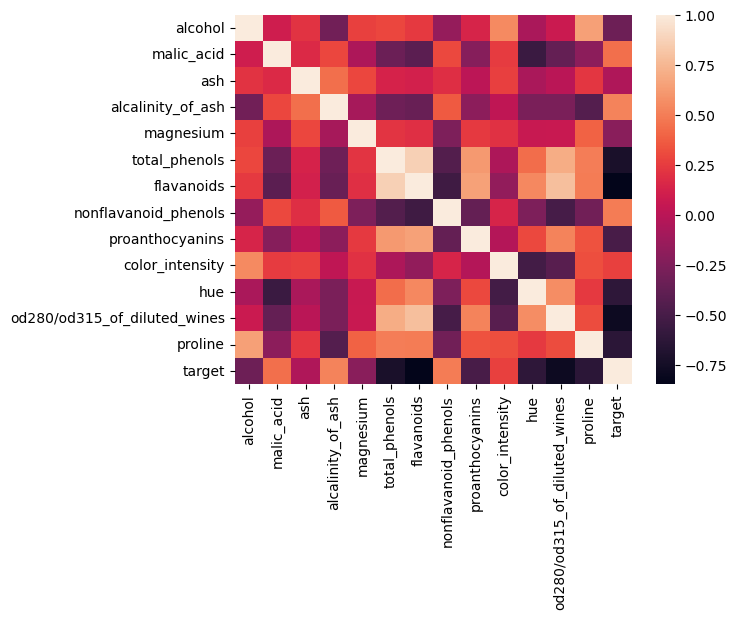

In [88]:
sns.heatmap(data.corr())

<AxesSubplot:xlabel='alcalinity_of_ash', ylabel='nonflavanoid_phenols'>

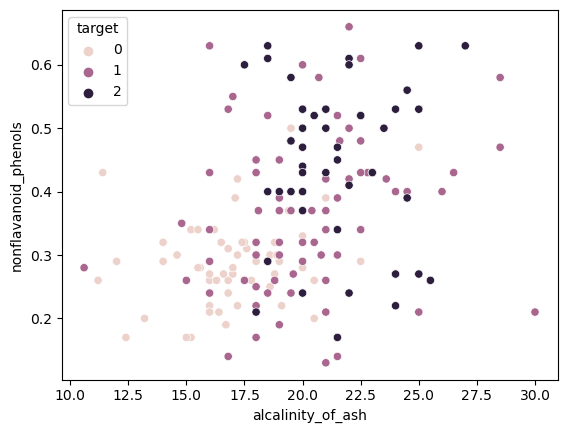

In [89]:
features = ["alcalinity_of_ash", "nonflavanoid_phenols"]
sns.scatterplot(x=data[features[0]], y=data[features[1]], hue=data["target"])

## Training sklearn implementation for benchmark

In [90]:
from sklearn import tree
from sklearn.model_selection import train_test_split

model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=4)
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1])
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.8

[Text(0.5769230769230769, 0.9, 'proline <= 755.0\nentropy = 1.543\nsamples = 133\nvalue = [43, 58, 32]'),
 Text(0.3076923076923077, 0.7, 'color_intensity <= 4.85\nentropy = 1.011\nsamples = 85\nvalue = [1, 55, 29]'),
 Text(0.15384615384615385, 0.5, 'malic_acid <= 3.925\nentropy = 0.266\nsamples = 54\nvalue = [1, 52, 1]'),
 Text(0.07692307692307693, 0.3, 'entropy = 0.0\nsamples = 50\nvalue = [0, 50, 0]'),
 Text(0.23076923076923078, 0.3, 'proanthocyanins <= 1.685\nentropy = 1.5\nsamples = 4\nvalue = [1, 2, 1]'),
 Text(0.15384615384615385, 0.1, 'entropy = 1.0\nsamples = 2\nvalue = [1, 0, 1]'),
 Text(0.3076923076923077, 0.1, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.46153846153846156, 0.5, 'flavanoids <= 1.385\nentropy = 0.459\nsamples = 31\nvalue = [0, 3, 28]'),
 Text(0.38461538461538464, 0.3, 'entropy = 0.0\nsamples = 27\nvalue = [0, 0, 27]'),
 Text(0.5384615384615384, 0.3, 'alcohol <= 13.305\nentropy = 0.811\nsamples = 4\nvalue = [0, 3, 1]'),
 Text(0.46153846153846156, 0

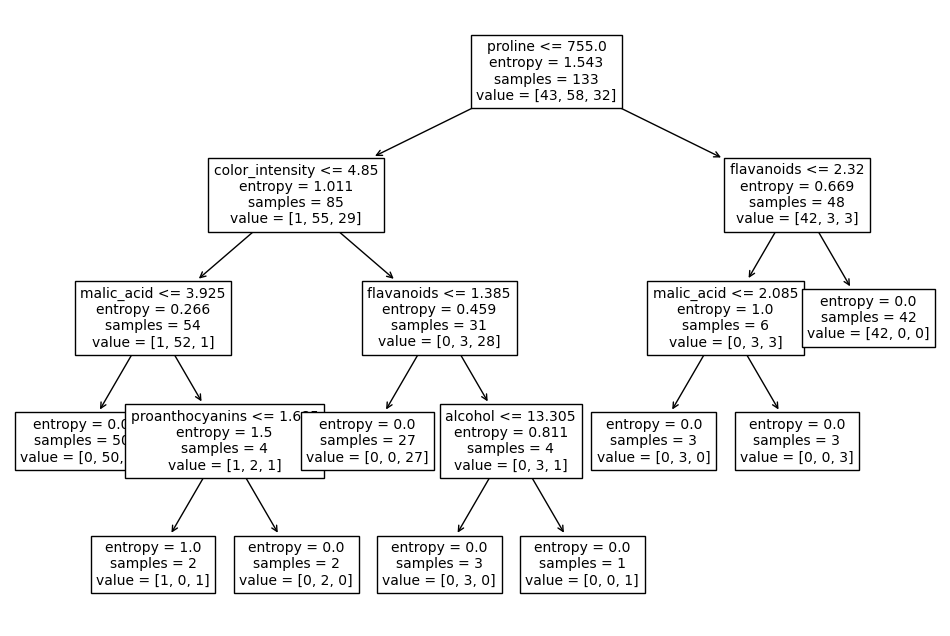

In [91]:
plt.figure(figsize=(12,8))
tree.plot_tree(model, feature_names=data.columns, fontsize=10)

In [92]:
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()

## Implementing the Node Class, which will constitue our tree

In [93]:
class Node:
    
    def __init__(self, id, remaining_samples, criteria, criteria_value, entropy, all_classes):
        self.id = id
        self.remaining = remaining_samples
        self.criteria_id = criteria
        self.criteria = data.columns[criteria]
        self.parameter = criteria_value
        self.entropy = entropy
        # Children nodes
        self.left = None
        self.right = None
        # Remanining samples by class
        self.split = np.zeros(np.unique(all_classes).shape[0])
        for k in self.remaining:
            self.split[all_classes[k]] += 1
        
    def __str__(self):
        if self.parameter == None:
            return f"Node {self.id}. No criteria. Entropy : {self.entropy}. Remaining classes: {self.split}"
        elif self.right == None and self.left == None:
            return f"Node {self.id}. Criteria: {self.criteria} <= {self.parameter}. Entropy : {self.entropy}. Remaining classes: {self.split}"
        else:
            return f"Node {self.id}. Criteria: {self.criteria} <= {self.parameter}. Entropy : {self.entropy}. Remaining classes: {self.split}. Children : {self.left.id} & {self.right.id}"

## Implementing the Tree

In [94]:
class MyDecisionTree:
    
    def __init__(self, max_depth=4):
        self.nodes = []
        self.node_index = 0
        self.max_depth = max_depth
        
    def __str__(self):
        for node in self.nodes:
            print(node)
        return ""
    
    def train(self, X, Y):
        self.X = X
        self.Y = Y
        # Number of features
        self.N = self.X.shape[1]
        # Index of all samples to start, we will then split them recursively down the tree
        self.index = [_ for _ in range(self.X.shape[0])]
        
        self.root = self.create_tree(self.index, 0)
    
    def create_tree(self, samples, current_depth):
        # We stop if max tree depth reached or nothing left to categorize
        if current_depth > self.max_depth or len(samples) == 0:
            return None
        
        # Checking if all classes are identical in input samples
        if self.Y[samples].sum() == self.Y[samples][0] * self.Y[samples].shape[0]:
            # Yes ? Then data is already perfectly classified
            node = Node(self.node_index, samples, None, None, 0, self.Y)
            self.node_index += 1
            self.nodes.append(node)
            return node
    
        # Find the best feature to split samples on
        feature, entropy, parameter, split_1, split_2 = self.find_feature(samples)
        
        node = Node(self.node_index, samples, feature, parameter, entropy, self.Y)
        self.nodes.append(node)
        self.node_index += 1
        current_depth += 1
        
        node.left = self.create_tree(split_1, current_depth)
        node.right = self.create_tree(split_2, current_depth)
        
        return node
    
    def find_feature(self, samples):
        # Finds best feature to split samples by iterating over all, and finding the minimum entropy
        min_feature = -1
        min_entropy = 1_000_000
        min_parameter = -1
        min_split_1_data = []
        min_split_2_data = []
        
        for i in range(self.N):
            # We get the minimum entropy possible for each feature
            feature_parameter, feature_entropy, feature_split_1_data, feature_split_2_data = self.calc_entropy(i, samples)
            if feature_entropy < min_entropy:
                min_entropy = feature_entropy
                min_parameter = feature_parameter
                min_split_1_data = feature_split_1_data
                min_split_2_data = feature_split_2_data
                min_feature = i
        
        return min_feature, min_entropy, min_parameter, min_split_1_data, min_split_2_data
    
    def calc_entropy(self, feature_id, samples):
        # We create different parameters to check for this feature
        testing_params = np.linspace(self.X[samples, feature_id].min(), self.X[samples, feature_id].max(), 30)
        min_feature_parameter = -1
        min_feature_entropy = 1_000_000
        min_1_samples = []
        min_2_samples = []
        for j in testing_params:
            # For each parameter, we calculate entropy and will ultimately the 'minimizer' parameter
            split_1_samples = []
            split_2_samples = []
            # Supposes Y classes to categorize start from 0 and are consecutive
            split_1_classes = np.zeros(np.unique(self.Y).shape[0])
            split_2_classes = np.zeros(np.unique(self.Y).shape[0])
            
            for k in samples:
                # We split samples on whether their feature value is over or under the current tested value ('testing_params')
                if self.X[k, feature_id] <= j:
                    split_1_samples.append(k)
                    split_1_classes[self.Y[k]] += 1
                else:
                    split_2_samples.append(k)
                    split_2_classes[self.Y[k]] += 1
            
            split_1_classes = split_1_classes / split_1_classes.sum()
            split_2_classes = split_2_classes / split_2_classes.sum()
            
            # Calculating entropy to check compared to current minimum entropy (found for another parameter value)
            entropy_1 = -split_1_classes.dot(np.nan_to_num(np.log2(split_1_classes.T), neginf=0))
            entropy_2 = -split_2_classes.dot(np.nan_to_num(np.log2(split_2_classes.T), neginf=0))
            curr_entropy = 1 / (split_1_classes.sum() + split_2_classes.sum()) * (split_1_classes.sum() * entropy_1 + split_2_classes.sum() * entropy_2)
            
            if curr_entropy < min_feature_entropy:
                min_feature_entropy = curr_entropy
                min_feature_parameter = j
                min_1_samples = split_1_samples
                min_2_samples = split_2_samples
        
        return min_feature_parameter, min_feature_entropy, min_1_samples, min_2_samples
    
    def predict(self, X_input):
        results = []
        for row in X_input:
            curr_node = self.root
            while curr_node.left != None:
                if row[curr_node.criteria_id] < curr_node.parameter:
                    curr_node = curr_node.left
                else:
                    curr_node = curr_node.right
            results.append(np.argmax(curr_node.split))
        return np.array(results)

## Training our tree and rough visualization

In [95]:
my_model = MyDecisionTree()
my_model.train(X_train, Y_train)
print(my_model)

Node 0. Criteria: proline <= 961.0344827586207. Entropy : 0.6570172015559983. Remaining classes: [43. 58. 32.]. Children : 1 & 8
Node 1. Criteria: color_intensity <= 6.533793103448276. Entropy : 0.5609532432253894. Remaining classes: [10. 58. 32.]. Children : 2 & 7
Node 2. Criteria: flavanoids <= 0.503448275862069. Entropy : 0.49685159111010024. Remaining classes: [10. 58. 12.]. Children : 3 & 4
Node 3. No criteria. Entropy : 0. Remaining classes: [0. 0. 5.]
Node 4. Criteria: od280/od315_of_diluted_wines <= 1.5517241379310345. Entropy : 0.4607217373803537. Remaining classes: [10. 58.  7.]. Children : 5 & 6
Node 5. No criteria. Entropy : 0. Remaining classes: [0. 0. 2.]
Node 6. Criteria: alcohol <= 13.780000000000001. Entropy : 0.4314049809365946. Remaining classes: [10. 58.  5.]
Node 7. No criteria. Entropy : 0. Remaining classes: [ 0.  0. 20.]
Node 8. No criteria. Entropy : 0. Remaining classes: [33.  0.  0.]



## Calculating our accuracy

In [96]:
predicted = my_model.predict(X_test)
print(((predicted == Y_test).sum() / predicted.shape[0]))

0.8444444444444444
